In [481]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import yfinance as yf


In [607]:
#https://finance.yahoo.com/most-active/heatmap

symbols = [
    #"DIA", 
    "MSFT", "AAPL",
    "AMZN",
    #"VAW", "VB", "XRT", 
    #"IVV", 
    "GOOG", "JNJ", "SHOP", 
    #"AMC", 
    "PLD", 
    "AMT", "CCI", "EQIX", 
    #"GME", 
    "UBER", "TSLA",
    "NFLX", "NVDA", "TXN", "COST", "INTC", "PEP", "ADBE",
    "NEM", "SCCO", "JPM", "TMO", "MSOS",
    "VBF"
]
symbols = [
    # from my Investopedia
    "IVV", "DIA", "AAPL", "GOOG", "VB", "VAW", "XRT", "JNJ", "PLD", "JPM", "TMO", #"PLTR",
    
    # new stonks to consider
    "MSFT", "AMZN", "AMT", "CCI", "EQIX", #"UBER", 
    #"TSLA", 
    "NFLX", "NVDA", "TXN", "COST", "INTC", "PEP", "ADBE",
    "NEM",  #"MSOS", 
    "VBF",
    "PFE", "WFC",
    
    "BAC", "CSCO", "XOM", "T",  "AZN", 
    "BABA", "BMY", "GE", "AMD", "C", #"BACHF", 
    "SNAP",
    
    # blacklisted (useless?)
    "SCCO", "VAW", "V",
]
symbols = list(set(symbols))

symbols.sort()

def get_history(*symbols):
    dfs = []
    for symbol in symbols:
        hist = yf.Ticker(symbol).history(period="5y")
        rename = {col: f"{symbol}_{col}" for col in hist.columns}
        hist = hist.rename(columns=rename)
        hist = hist.sort_index()
        hist
        close = hist[f"{symbol}_Close"].values
        delta = close[1:] - close[:-1]
        hist[f"{symbol}_Delta"] = [None] + list(delta)
        hist[f"{symbol}_Return"] = [None] + list(delta / close[:-1])
        hist = hist.dropna()
        hist = hist[[f"{symbol}_Close", f"{symbol}_Delta", f"{symbol}_Return"]]
        hist
        dfs.append(hist)
        
    df = dfs[0]
    
    for other in dfs[1:]:
        df = df.merge(other, on="Date")
        
    df = df.dropna()
    return df

df = get_history(*symbols)
df

,AAPL_Close,AAPL_Delta,AAPL_Return,ADBE_Close,ADBE_Delta,ADBE_Return,AMD_Close,AMD_Delta,AMD_Return,AMT_Close,...,VBF_Return,WFC_Close,WFC_Delta,WFC_Return,XOM_Close,XOM_Delta,XOM_Return,XRT_Close,XRT_Delta,XRT_Return
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-03,33.189762,0.194698,0.005901,120.040001,0.139999,0.001168,13.030000,-0.870000,-0.062590,106.426987,...,0.002671,51.611412,0.157757,0.003066,66.886208,-0.681351,-0.010084,40.104321,-0.582039,-0.014306
2017-03-06,33.085289,-0.104473,-0.003148,120.150002,0.110001,0.000916,13.040000,0.010000,0.000767,105.543709,...,-0.001066,51.366016,-0.245396,-0.004755,67.186333,0.300125,0.004487,39.747589,-0.356731,-0.008895
2017-03-07,33.128029,0.042740,0.001292,119.980003,-0.169998,-0.001415,13.050000,0.010000,0.000767,105.534508,...,-0.001067,51.094322,-0.271694,-0.005289,66.934875,-0.251457,-0.003743,39.372078,-0.375511,-0.009447
2017-03-08,33.004562,-0.123466,-0.003727,119.599998,-0.380005,-0.003167,13.220000,0.170000,0.013027,104.191177,...,-0.007475,51.015442,-0.078880,-0.001544,65.726257,-1.208618,-0.018057,39.775749,0.403671,0.010253
2017-03-09,32.928577,-0.075985,-0.002302,119.910004,0.310005,0.002592,13.330000,0.110000,0.008321,103.970352,...,-0.013986,51.444893,0.429451,0.008418,66.245384,0.519127,0.007898,39.268810,-0.506939,-0.012745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12,131.240005,-1.759995,-0.013233,506.029999,1.989990,0.003948,78.580002,-4.180000,-0.050507,241.500000,...,-0.006166,40.770000,0.270000,0.006667,55.500000,-0.369999,-0.006622,92.669998,0.459999,0.004989
2021-04-13,134.429993,3.189987,0.024307,514.859985,8.829987,0.017450,80.190002,1.610001,0.020489,243.009995,...,0.002956,39.790001,-0.980000,-0.024037,55.709999,0.209999,0.003784,91.970001,-0.699997,-0.007554
2021-04-14,132.029999,-2.399994,-0.017853,510.630005,-4.229980,-0.008216,78.550003,-1.639999,-0.020451,241.679993,...,-0.003102,41.990002,2.200001,0.055290,57.320000,1.610001,0.028900,92.199997,0.229996,0.002501


In [608]:
for symbol in symbols:
    print(symbol, df[f"{symbol}_Return"].mean())

AAPL 0.0015556035242420354
ADBE 0.0016468488081148756
AMD 0.0023753709530463254
AMT 0.0009660128536623842
AMZN 0.0015210058087815007
AZN 0.0007900148750896578
BABA 0.0010520416492445005
BAC 0.0007564725047929966
BMY 0.0003859928578803417
C 0.000578558920811671
CCI 0.0009183750136976429
COST 0.0009069470129927678
CSCO 0.0007086675107053557
DIA 0.0006457722186114529
EQIX 0.0008475214967401577
GE -0.0002884267243955304
GOOG 0.0011391212696404164
INTC 0.0009360144443449308
IVV 0.0007005779528514974
JNJ 0.00044729466330396535
JPM 0.0008074310803703903
MSFT 0.00157516564743226
NEM 0.0009312559411100653
NFLX 0.0016353689854369559
NVDA 0.0022663809476699353
PEP 0.00046719238874594994
PFE 0.0004027132285531415
PLD 0.0010358170705279464
SCCO 0.0010916857925047803
SNAP 0.0017532509954224064
T 4.01576183710031e-05
TMO 0.0012382478600707918
TXN 0.0011728403871517593
V 0.0010785410036651657
VAW 0.0005885736158116598
VB 0.0006476401351458078
VBF 0.0003010691474992659
WFC 9.660969441664235e-05
XOM 3.0

In [609]:
# https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/

rho 0.02162909473007883 1.0009643201542917 0.45171378415937957
rho -0.9783709052699212 0.000964320154291709 -0.5482862158406204
cluster 0 ['AMT', 'CCI', 'EQIX']
cluster 1 ['BAC', 'C', 'GE', 'JPM', 'WFC', 'XOM']
cluster 2 ['AAPL', 'ADBE', 'AMD', 'AMZN', 'AZN', 'BABA', 'BMY', 'COST', 'CSCO', 'DIA', 'GOOG', 'INTC', 'IVV', 'JNJ', 'MSFT', 'NFLX', 'NVDA', 'PEP', 'PFE', 'PLD', 'SCCO', 'T', 'TMO', 'TXN', 'V', 'VAW', 'VB', 'XRT']
cluster 3 ['NEM']
cluster 4 ['SNAP']
cluster 5 ['VBF']


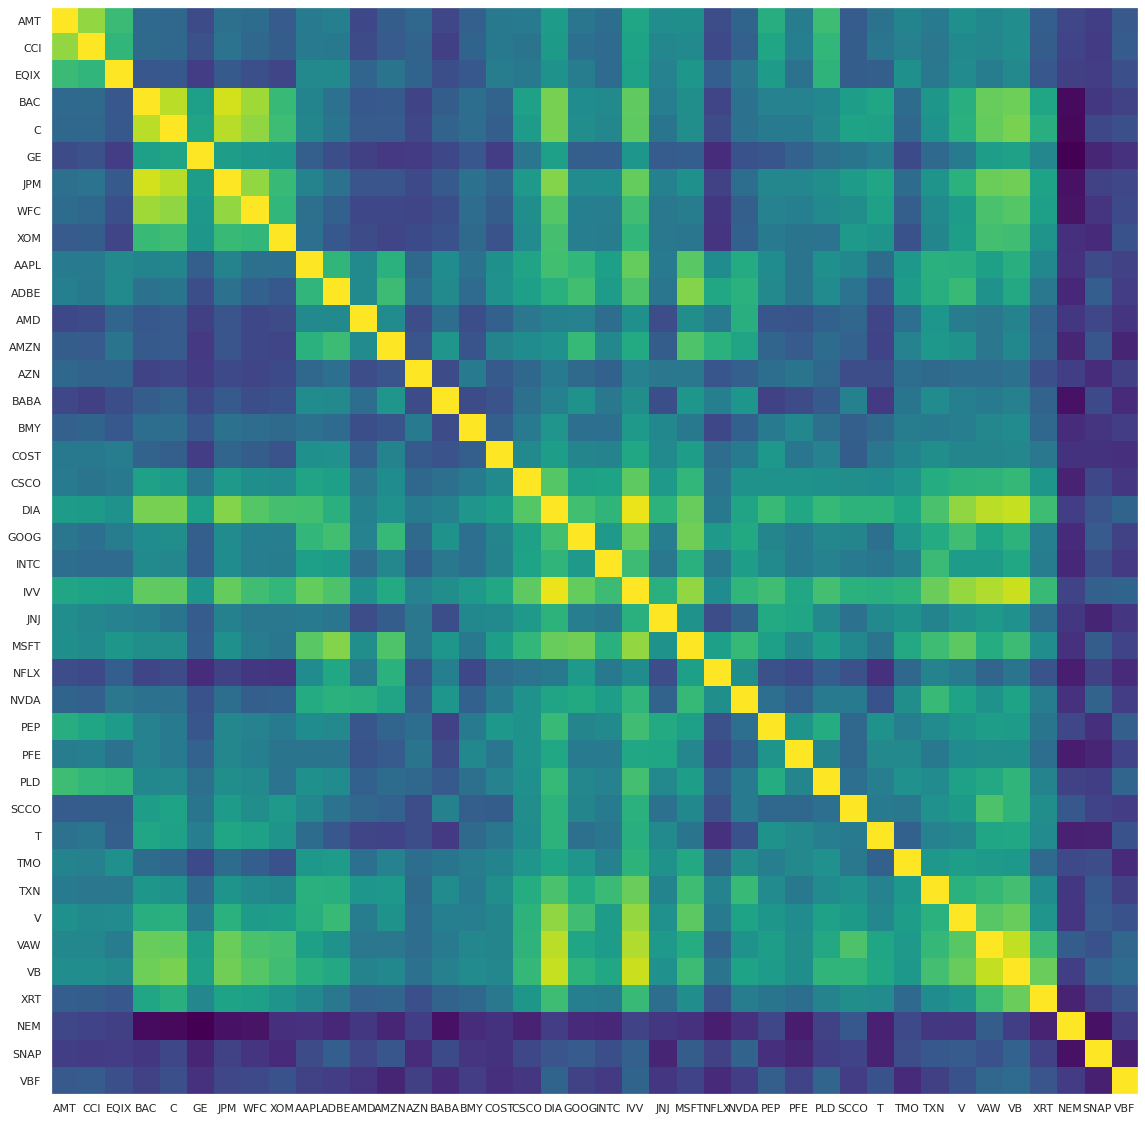

In [610]:
from sklearn.cluster import AffinityPropagation, SpectralClustering

data = np.asmatrix(df[[f"{symbol}_Return" for symbol in symbols]].T)
data = data / np.std(data, axis=1)
rho = np.cov(data)

distance = 1 - rho
affinity = -distance
ap = AffinityPropagation(affinity="precomputed", random_state=None)
#sc = SpectralClustering(affinity="precomputed", random_state=None)
print("rho", rho.min(), rho.max(), rho.mean())
print("rho", affinity.min(), affinity.max(), affinity.mean())
result = ap.fit_predict(affinity)
#print("clusters", result)

clusters = list(set(result))
new_symbols = []

for cluster in clusters:
    for i, cluster_id in enumerate(result):
        if cluster_id == cluster:
            new_symbols.append(symbols[i])
    print("cluster", cluster, [symbol for idx, symbol in enumerate(symbols) if result[idx] == cluster])

data = np.asmatrix(df[[f"{symbol}_Return" for symbol in new_symbols]].T)
data = data / np.std(data, axis=1)
rho = np.cov(data)

plt.figure(figsize=(20,20))
plt.imshow(rho, cmap="viridis")
#plt.axis("off")
ax = plt.gca()
ax.grid(False)
plt.xticks(ticks=range(len(symbols)), labels=new_symbols)
plt.yticks(ticks=range(len(symbols)), labels=new_symbols)
plt.show()

In [611]:
import cvxopt as opt
from cvxopt import blas, solvers

def optimal_portfolio_new(returns, N=50):
    """
    Inspired by
    https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/
    
    QP docs here:
    https://cvxopt.org/userguide/coneprog.html#quadratic-programming
    
    Page 16 here:
    https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi1ko729-7vAhXigP0HHVSBDAkQFjAAegQIBRAD&url=https%3A%2F%2Fpublikationen.bibliothek.kit.edu%2F1000007246%2F11235&usg=AOvVaw2YCB12QbGK3IhadaGuVk_f
    """
    n = len(returns)
    returns = np.asmatrix(returns)
    
    #N = 1000
    #eps = 1e-1
    #mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    #print(mus)
    mean_returns = np.mean(returns, axis=1)
    
    desired_returns = list(np.linspace(np.min(mean_returns), np.max(mean_returns), num=N))
    
    #mus = list(np.linspace(np.min(mean_returns)+eps, np.max(mean_returns)-eps, num=N))
    #print(mus)
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # qp(P, q, G, h, A, b):
    #     minimize (1/2) x.T * P * x + q.T * x
    #     subject to:
    #         Gx <= h
    #         Ax = b
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    #A = opt.matrix(1.0, (1, n))
    #b = opt.matrix(1.0)
    
    A = np.zeros(shape=(2,n))
    b = np.zeros(shape=(2,))
    
    for i in range(n):
        A[0, i] = 1.0
        A[1, i] = mean_returns[i]
    
    b[0] = 1.0
    b[1] = 0.0
    
    A = opt.matrix(A)
    b = opt.matrix(b)
    
    q = 0*pbar
        
    
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = []
    
    for desired_return in desired_returns:
        b[1] = desired_return
        portfolio = solvers.qp(S, q, G, h, A, b)['x']
        portfolio = np.array(portfolio).reshape(-1, 1)
        portfolios.append(portfolio)
        
    S = np.asmatrix(S)
        
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [np.asscalar(np.dot(mean_returns.transpose(), x)) for x in portfolios]
    risks = [np.asscalar(np.sqrt(np.dot(x.transpose(), S.dot(x)))) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    #m1 = np.polyfit(returns, risks, 2)
    #x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    #wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    #return np.asarray(wt), returns, risks, portfolios
    return returns, risks, portfolios

In [612]:
%%capture
return_vec = np.asmatrix(df[[f"{symbol}_Return" for symbol in symbols]].T)
returns, risks, portfolios = optimal_portfolio_new(return_vec, N=1000)

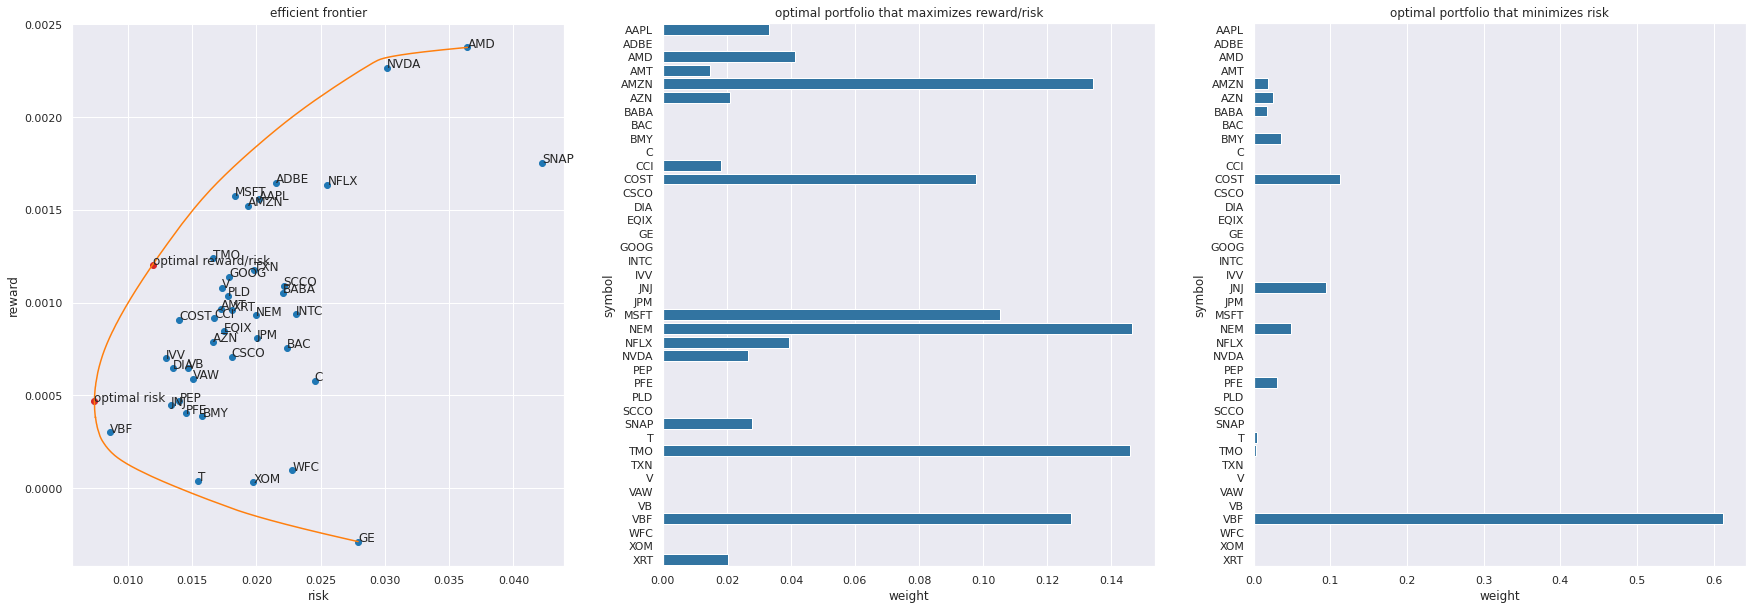

In [613]:
#print(returns, risks)

zipped = list(zip(returns, risks))

opt_reward = returns[np.argmin(risks)]
#print(returns)

data = pd.DataFrame(
    data= {
        "reward": returns,
        "risk": risks,
    }
)

below_data = data.query("reward <= @opt_reward")
above_data = data.query("reward >= @opt_reward")


plt.figure(figsize=(30,10))

plt.subplot(1, 3, 1)

for data in [below_data, above_data]:
    sns.lineplot(x="risk", y="reward", data=data, color="tab:orange")

mean_returns = [df[f"{symbol}_Return"].mean() for symbol in symbols]
mean_risks = [df[f"{symbol}_Return"].std() for symbol in symbols]

plt.scatter(mean_risks, mean_returns, color="tab:blue")

for i, symbol in enumerate(symbols):
    plt.annotate(symbol, (mean_risks[i], mean_returns[i]))
    
idx_rr = np.argmax(np.array(returns) / np.array(risks))
#print(idx)
plt.scatter([risks[idx_rr]], [returns[idx_rr]], color="tab:red")
plt.annotate("optimal reward/risk", ([risks[idx_rr], returns[idx_rr]]))
#print(returns[idx], risks[idx])

idx_rk = np.argmin(np.array(risks))
#print(idx)
plt.scatter([risks[idx_rk]], [returns[idx_rk]], color="tab:red")
plt.annotate("optimal risk", ([risks[idx_rk], returns[idx_rk]]))
#print(returns[idx], risks[idx])

plt.title("efficient frontier")

plt.subplot(1, 3, 2)

data = pd.DataFrame(
    data = {
        "symbol": symbols,
        "weight": [wt for wt in portfolios[idx_rr].reshape(-1)]
    }
)

sns.barplot(y="symbol", x="weight", data=data, color="tab:blue")

plt.title("optimal portfolio that maximizes reward/risk")


plt.subplot(1, 3, 3)

data = pd.DataFrame(
    data = {
        "symbol": symbols,
        "weight": [wt for wt in portfolios[idx_rk].reshape(-1)]
    }
)

sns.barplot(y="symbol", x="weight", data=data, color="tab:blue")

plt.title("optimal portfolio that minimizes risk")


plt.show()

In [617]:
def num_shares(cash, idx):
    weights = portfolios[idx].reshape(-1)
    costs = np.array([df[f"{symbol}_Close"].values[-1] for symbol in symbols])
    portfolio = dict()
    for symbol, weight, cost in zip(symbols, weights, costs):
        shares = round(weight/cost*cash)
        assert weight <= 1
        buy_cost = shares * cost
        
        portfolio[symbol] = {
            "shares": shares,
            "purchase_cost": buy_cost
        }
    return portfolio
    
num_shares(160000, idx_rr)

{'AAPL': {'shares': 40, 'purchase_cost': 5359.1998291015625},
 'ADBE': {'shares': 0, 'purchase_cost': 0.0},
 'AMD': {'shares': 80, 'purchase_cost': 6563.2000732421875},
 'AMT': {'shares': 9, 'purchase_cost': 2221.2000274658203},
 'AMZN': {'shares': 6, 'purchase_cost': 20334.0},
 'AZN': {'shares': 66, 'purchase_cost': 3356.099899291992},
 'BABA': {'shares': 0, 'purchase_cost': 0.0},
 'BAC': {'shares': 0, 'purchase_cost': 0.0},
 'BMY': {'shares': 0, 'purchase_cost': 0.0},
 'C': {'shares': 0, 'purchase_cost': 0.0},
 'CCI': {'shares': 16, 'purchase_cost': 2858.239990234375},
 'COST': {'shares': 42, 'purchase_cost': 15582.0},
 'CSCO': {'shares': 0, 'purchase_cost': 0.0},
 'DIA': {'shares': 0, 'purchase_cost': 0.0},
 'EQIX': {'shares': 0, 'purchase_cost': 0.0},
 'GE': {'shares': 0, 'purchase_cost': 0.0},
 'GOOG': {'shares': 0, 'purchase_cost': 0.0},
 'INTC': {'shares': 0, 'purchase_cost': 0.0},
 'IVV': {'shares': 0, 'purchase_cost': 0.0},
 'JNJ': {'shares': 0, 'purchase_cost': 0.0},
 'JPM': 